In [71]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
%config Completer.use_jedi = False
#Command to stop autocompletion from taking eternity

### List of names of classes

In [200]:
classes_names_indiana_pines = ["Ground", "Alfalfa", "Corn-notill", 
"Corn-mintill", "Corn", "Grass-pasture", "Grass-trees",
"Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill",
"Soybean-mintill", "Soybean-clean", "Wheat", "Woods", 
"Buildings-grass-Trees-Drives", "Stone-Steel-Towers"]

classes_names_salinas = ["Ground", "Brocoli_green_weeds_1", 
"Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", 
"Fallow_smooth", "Stubble", "Celery", "Grapes_untrained",
"Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", 
"Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", 
"Vinyard_untrained", "Vinyard_vertical_trellis"]

### Load and Display Images

In [4]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [5]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [6]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


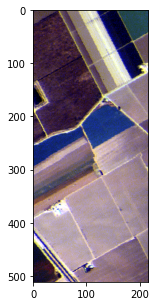

In [15]:
plot_RGB(salinas)

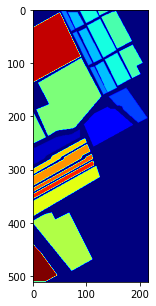

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


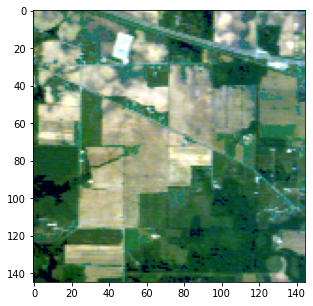

In [17]:
plot_RGB(indiana_pines)

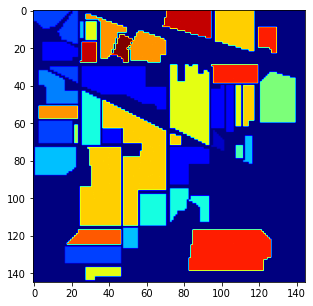

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### PCA

In [62]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()
values, count = np.unique(Y1, return_counts=True)
print(values, '\n', count)
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()

print(X2.shape)
print(Y2.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 
 [56975  2009  3726  1976  1394  2678  3959  3579 11271  6203  3278  1068
  1927   916  1070  7268  1807]
(111104, 204)
(111104,)
(21025, 200)
(21025,)


In [289]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=1, stratify=Y1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1, stratify=Y2)
print(X1_train.shape)

(88883, 204)


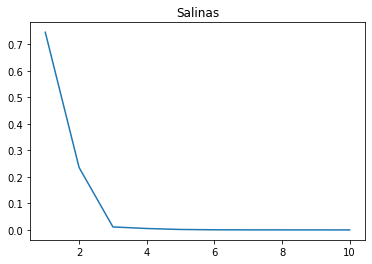

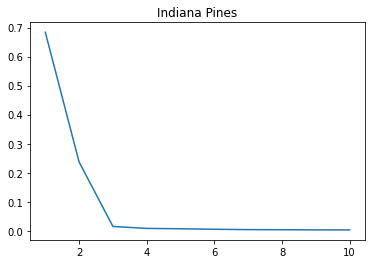

In [22]:
from sklearn import decomposition

def pca_components(X, name):
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1_train, "Salinas")
pca_components(X2_train, "Indiana Pines")

Variance greater than 0.999: 5


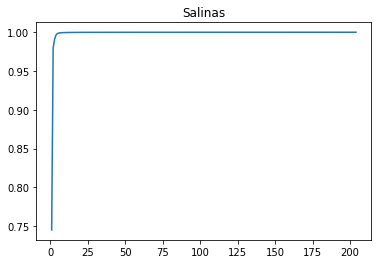

Variance greater than 0.999: 68


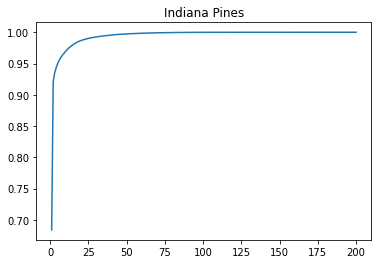

In [24]:
def pca_components_cumsum(X, name):
    pca = decomposition.PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.999))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1_train, "Salinas")
pca_components_cumsum(X2_train, "Indiana Pines")

In [296]:
pca1 = decomposition.PCA(n_components=20)
pca1.fit(X1_train)
print(pca1.components_.shape)

X1_train_pca = pca1.transform(X1_train)
print(X1_train_pca.shape)
X1_test_pca = pca1.fit_transform(X1_test)
print(X1_test_pca.shape)

(20, 204)
(88883, 20)
(22221, 20)


In [26]:
pca2 = decomposition.PCA(n_components=68)
pca2.fit(X2_train)
print(pca2.components_.shape)

X2_train_pca = pca2.transform(X2_train)
print(X2_train_pca.shape)

(68, 200)
(16820, 68)


### Classifier

In [27]:
from sklearn.utils import class_weight
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [28]:
def class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(17), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)

{0: 0.11470872157551042, 1: 3.2531256405001026, 2: 1.7540336585519876, 3: 3.3074541557513695, 4: 4.68832812895603, 5: 2.4404516100689717, 6: 1.650803084557895, 7: 1.826076952155548, 8: 0.5798535544108514, 9: 1.0536078368152033, 10: 1.9937551591716614, 11: 6.11940956157744, 12: 3.3915565188192556, 13: 7.134857436424351, 14: 6.107971412864211, 15: 0.8992197869791835, 16: 3.6167844005338714}
{0: 0.11477029564609809, 1: 26.88618925831202, 2: 0.8660817268083704, 3: 1.490077958894401, 4: 5.218416480516257, 5: 2.5605894531725735, 6: 1.6941982272361, 7: 44.17016806722689, 8: 2.5873738616785626, 9: 61.838235294117645, 10: 1.27239167271847, 11: 0.5037738109500419, 12: 2.08560658664815, 13: 6.032998565279771, 14: 0.9776796093931643, 15: 3.2040536421822616, 16: 13.29854522454143}


### One vs rest classifier

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline, Pipeline

In [92]:
clf = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=100), n_jobs=4)

In [27]:
clf_pipeline = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=4)
clf = make_pipeline(StandardScaler(), clf_pipeline)

### One vs one classifier


In [338]:
from sklearn.multiclass import OneVsOneClassifier

In [343]:
pipeline_one_vs_one = OneVsOneClassifier(
    RandomForestClassifier(n_jobs=6, max_features=4, n_estimators=500), n_jobs=6)


In [299]:
from sklearn.tree import DecisionTreeClassifier
base_model = RandomForestClassifier(n_jobs=6, class_weight=class_weights1)

In [346]:
from sklearn.decomposition import PCA
pipe = Pipeline([('pca', PCA(n_components=17)), 
    ('forest', RandomForestClassifier(n_jobs=6, max_features=4, n_estimators=500, class_weight=None))])

In [348]:
pipe_onevsone_pca = Pipeline([('pca', PCA(n_components=17)), 
    ('forest', RandomForestClassifier(n_jobs=6, max_features=4, n_estimators=500, class_weight=None))])
pipe_onevsone_pca = OneVsOneClassifier(pipe_onevsone_pca, n_jobs=6)

### Fit

In [349]:
pipe_onevsone_pca.fit(X1_train, Y1_train)
pipe_onevsone_pca.score(X1_test, Y1_test)

0.9409567526213942

In [344]:
pipeline_one_vs_one.fit(X1_train, Y1_train)
pipeline_one_vs_one.score(X1_test, Y1_test)

0.9342963863012466

In [347]:
%%time
pipe.fit(X1_train, Y1_train)
pipe.score(X1_test, Y1_test)

CPU times: user 3min 50s, sys: 9.59 s, total: 4min
Wall time: 39.3 s


0.9423518293506142

In [300]:
%%time
base_model.fit(X1_train, Y1_train)
base_model.score(X1_test, Y1_test)

CPU times: user 52.3 s, sys: 54.7 ms, total: 52.3 s
Wall time: 9.07 s


RandomForestClassifier(class_weight={0: 0.11470872157551042,
                                     1: 3.2531256405001026,
                                     2: 1.7540336585519876,
                                     3: 3.3074541557513695, 4: 4.68832812895603,
                                     5: 2.4404516100689717,
                                     6: 1.650803084557895, 7: 1.826076952155548,
                                     8: 0.5798535544108514,
                                     9: 1.0536078368152033,
                                     10: 1.9937551591716614,
                                     11: 6.11940956157744,
                                     12: 3.3915565188192556,
                                     13: 7.134857436424351,
                                     14: 6.107971412864211,
                                     15: 0.8992197869791835,
                                     16: 3.6167844005338714},
                       n_jobs=6)

In [327]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


grid_params = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'forest__max_features': [3, 4, 5],
    'pca__n_components': [15, 17, 18, 20, 22, 24, 25],
    'forest__n_estimators': [100, 200, 500]
}

cv = StratifiedKFold(n_splits=3)
# Instantiate new gridsearch object
# gs = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=cv, n_jobs=6, verbose=4)
#gs = RandomizedSearchCV(estimator=pipe, param_distributions=grid_params, n_iter=10, cv=cv, n_jobs=6, verbose=4)
gs = HalvingGridSearchCV(estimator=pipe, param_grid=grid_params, cv=cv, n_jobs=6, verbose=4)
# Fit model to our training data
gs.fit(X1_train, Y1_train)

# Score the model on our testing data
gs.score(X1_test, Y1_test)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3291
max_resources_: 88883
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 63
n_resources: 3291
Fitting 3 folds for each of 63 candidates, totalling 189 fits
----------
iter: 1
n_candidates: 21
n_resources: 9873
Fitting 3 folds for each of 21 candidates, totalling 63 fits
----------
iter: 2
n_candidates: 7
n_resources: 29619
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 3
n_resources: 88857
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 4min 38s, sys: 11.6 s, total: 4min 49s
Wall time: 8min 8s


0.9402817154943522

In [328]:
import pandas as pd
df = pd.DataFrame(gs.cv_results_)
df

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_features,param_forest__n_estimators,param_pca__n_components,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,3291,0.584297,0.060272,0.112278,0.007576,3,100,15,"{'forest__max_features': 3, 'forest__n_estimat...",...,0.870556,0.869526,0.875074,0.007131,32,1.000000,1.000000,0.999544,0.999848,0.000215
1,0,3291,0.570076,0.039542,0.120351,0.003247,3,100,17,"{'forest__max_features': 3, 'forest__n_estimat...",...,0.865087,0.861314,0.869602,0.009184,53,1.000000,1.000000,0.999544,0.999848,0.000215
2,0,3291,0.566024,0.060908,0.122627,0.005462,3,100,18,"{'forest__max_features': 3, 'forest__n_estimat...",...,0.859617,0.870438,0.867478,0.005615,70,1.000000,1.000000,0.999544,0.999848,0.000215
3,0,3291,0.544398,0.001734,0.121572,0.004089,3,100,20,"{'forest__max_features': 3, 'forest__n_estimat...",...,0.862352,0.866788,0.868085,0.005290,65,1.000000,1.000000,0.999544,0.999848,0.000215
4,0,3291,0.582348,0.050472,0.127067,0.018583,3,100,22,"{'forest__max_features': 3, 'forest__n_estimat...",...,0.851413,0.866788,0.866565,0.012282,79,1.000000,1.000000,0.999544,0.999848,0.000215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2,29619,34.796149,0.276541,1.450509,0.139224,5,500,17,"{'forest__max_features': 5, 'forest__n_estimat...",...,0.911172,0.913898,0.911777,0.001545,4,0.998835,0.998683,0.998936,0.998818,0.000104
90,2,29619,30.069756,0.283473,1.315121,0.106341,4,500,17,"{'forest__max_features': 4, 'forest__n_estimat...",...,0.910463,0.914506,0.911507,0.002153,6,0.998835,0.998683,0.998936,0.998818,0.000104
91,3,88857,113.334095,1.752044,3.965338,0.401569,4,500,17,"{'forest__max_features': 4, 'forest__n_estimat...",...,0.928796,0.930515,0.929526,0.000725,1,0.996202,0.996134,0.996320,0.996219,0.000077
92,3,88857,139.254940,1.122986,3.597495,0.190207,5,500,18,"{'forest__max_features': 5, 'forest__n_estimat...",...,0.927918,0.929502,0.928761,0.000651,3,0.996202,0.996134,0.996320,0.996219,0.000077


In [329]:
print(gs.best_params_)
clf = gs.best_estimator_

{'forest__max_features': 4, 'forest__n_estimators': 500, 'pca__n_components': 17}


In [259]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,15))
plot_tree(clf, class_names=classes_names_salinas)
plt.show()

KeyboardInterrupt: 

### Testing

In [37]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [85]:
def plot_classification_and_confusion_matrix(clf, X_test, Y_test):
    print(clf.score(X_test, Y_test))
    print(classification_report(Y_test, clf.predict(X_test)))

    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(clf, X_test, Y_test, ax=ax)
    plt.show()

0.9402817154943522
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     11395
           1       0.92      0.97      0.94       402
           2       0.94      0.98      0.96       745
           3       0.95      0.85      0.90       395
           4       0.93      0.90      0.91       279
           5       0.93      0.95      0.94       536
           6       0.94      0.96      0.95       792
           7       0.94      0.98      0.96       716
           8       0.88      0.93      0.91      2254
           9       0.96      0.95      0.95      1241
          10       0.96      0.93      0.95       656
          11       0.90      0.90      0.90       213
          12       0.93      0.94      0.94       385
          13       0.85      0.93      0.89       183
          14       0.89      0.83      0.86       214
          15       0.89      0.82      0.86      1454
          16       0.95      0.98      0.96       361

    acc

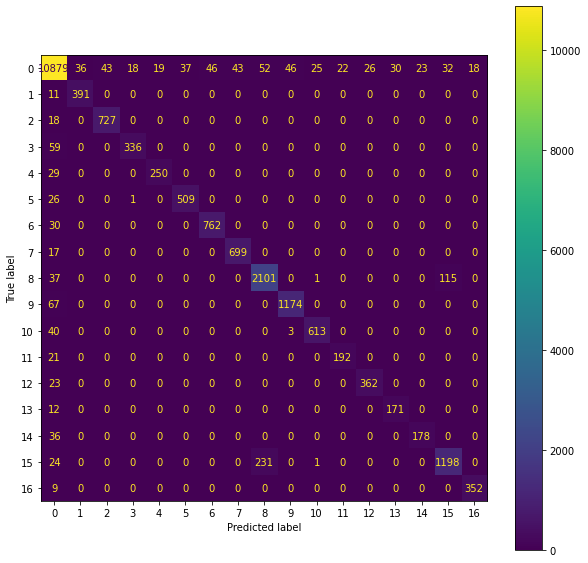

In [330]:
plot_classification_and_confusion_matrix(clf, X1_test, Y1_test)

(111104,)
(512, 217)


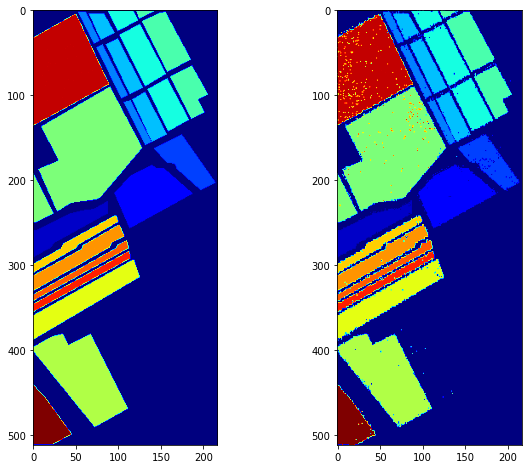

In [331]:
y1_predict = clf.predict(X1)
print(y1_predict.shape)
y1_predict_reshaped = y1_predict.reshape((salinas_gt.shape))
print(y1_predict_reshaped.shape)

plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(salinas_gt, cmap='jet')

plt.subplot(122)
plt.imshow(y1_predict_reshaped, cmap='jet')
plt.show()


In [264]:
def display_each_class(clf, X, ground_truth, name_classes, nb_col):
    y_predict = clf.predict(X)
    y_predict_reshaped = y_predict.reshape((ground_truth.shape))
    
    nb_classes = np.size(name_classes)
    nb_row = (nb_classes * 2 // nb_col) + 1
    print(nb_row, nb_col, nb_classes)
    index = 0
    plt.figure(figsize=(15,18))
    fig, axes = plt.subplots(nb_row, nb_col, figsize=(10,20))
    
    axes = axes.ravel()
    
    for i in range(nb_classes):
        axes[index].imshow(np.where(ground_truth != i, 1, 0), cmap="jet")
        axes[index].title.set_text(name_classes[i])
        axes[index].set_xticklabels([])
        axes[index].set_yticklabels([])
        index += 1
        
        axes[index].imshow(np.where(y_predict_reshaped != i, 1, 0), cmap="jet")
        axes[index].set_xticklabels([])
        axes[index].set_yticklabels([])
        index += 1
    plt.show()
    

6 6 17


<Figure size 1080x1296 with 0 Axes>

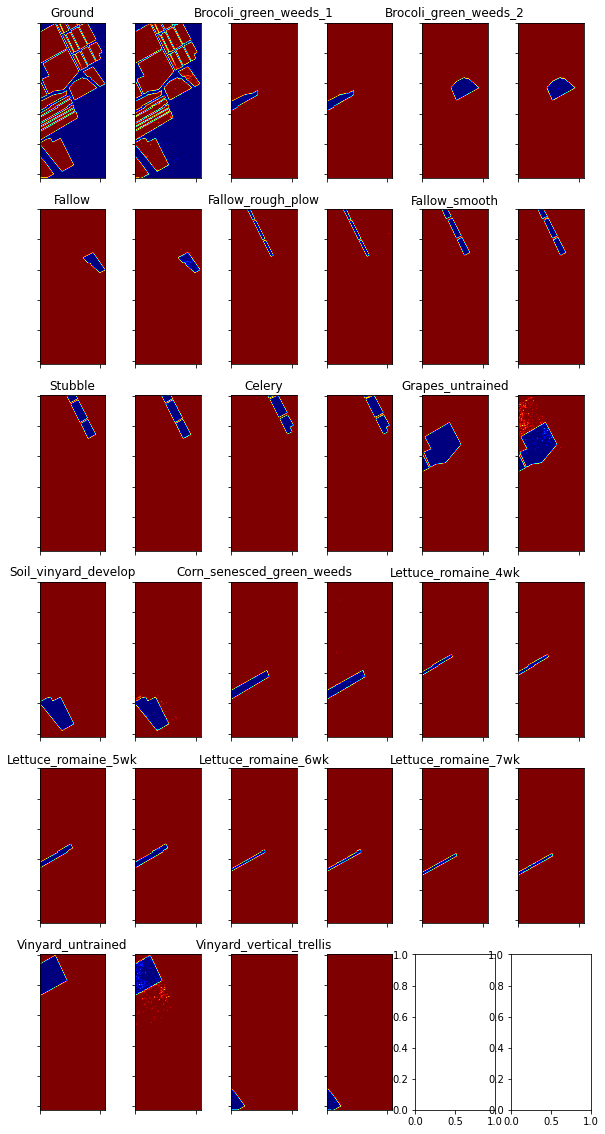

In [332]:
display_each_class(clf, X1, salinas_gt, classes_names_salinas, nb_col=6)

In [ ]:
from skimage.morphology import opening, closing
from skimage import morphology as morpho

In [40]:
y1_pred_rc = closing(y1_predict_reshaped, morpho.diamond(1))
y1_pred_rc = opening(y1_pred_rc, morpho.diamond(1))
print(classification_report(Y1, y1_pred_rc.flatten()))
print(classification_report(Y1, y1_predict))

plt.figure(figsize=(5,5))
plt.imshow(y1_pred_rc, cmap='jet')
plt.show()

NameError: name 'closing' is not defined